<a href="https://colab.research.google.com/github/gabcovm/intro_to_NLP/blob/main/NN2NN_Knowledge_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ALeRCEdata
from preprocess import ALeRCEDataset, PreprocessingData, ALeRCEDataloaders, ALeRCEHierarchDataset, DataSet, HierarchDataSet
from utils import splitData, plot_confusion_matrix, EarlyStopping, train_classifier
from models import MLP, TopBottomHierarch

Mounted at /content/drive
/content/drive/MyDrive/ALeRCEdata


In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer
from sklearn.preprocessing import QuantileTransformer
from torch.utils.data.sampler import WeightedRandomSampler
from itertools import cycle
import pickle
import math

import warnings
warnings.filterwarnings("ignore")

In [3]:
features = pd.read_parquet('features_for_ML_with_WISE.parquet')
crossmatch = pd.read_csv('dfcrossmatches_prioritized_v7.0.1.csv')

In [4]:
Data = PreprocessingData(features, crossmatch)
df_dataset = Data.data
df_labels = Data.labels

train_set, train_labels, val_set, val_labels, test_set, test_labels = splitData(df_dataset, df_labels, i=0)
unlab_dataset = features[~features.index.isin(df_dataset.index)]

In [5]:
hierarchDataloaders = ALeRCEDataloaders(train_data=train_set, 
                                train_labels=train_labels,
                                val_data=val_set,
                                val_labels=val_labels,
                                test_data=test_set, 
                                test_labels=test_labels,
                                level='bottom',
                                num_workers=2)
hier_train_dataloader = hierarchDataloaders.train
hier_val_dataloader = hierarchDataloaders.val
hier_test_dataloader = hierarchDataloaders.test
qt = hierarchDataloaders.qt

In [6]:
rm_nd_cols = ['n_det_1',
            'n_det_2',
            'n_pos_1',
            'n_pos_2',
            'n_neg_1',
            'n_neg_2',
            'first_mag_1',
            'first_mag_2',
            'MHPS_non_zero_1',
            'MHPS_non_zero_2',
            'MHPS_PN_flag_1',
            'MHPS_PN_flag_2',
            'mean_mag_1',
            'mean_mag_2',
            'min_mag_1',
            'min_mag_2',
            'W1','W2','W3','W4',  
            'iqr_1',
            'iqr_2', 
            'delta_mjd_fid_1',
            'delta_mjd_fid_2',
            'last_mjd_before_fid_1',
            'last_mjd_before_fid_2',
            'g-r_ml',
            'MHAOV_Period_1', 'MHAOV_Period_2',
            ]
unlab_dataset = unlab_dataset[(unlab_dataset['n_det_1']>5) | (unlab_dataset['n_det_2']>5)]
unlab_dataset.drop(columns=rm_nd_cols,inplace=True)
unlab_dataset.replace([-np.inf,np.inf],np.nan)
unlab_dataset.drop(columns=['Mean_1','Mean_2'],axis=1, inplace=True)
unlab_data = qt.transform(unlab_dataset.values)
unlab_data = np.nan_to_num(unlab_data, nan=-1)

### First Generation

We use as teacher the pretrained NN obtained from KD using the Balanced Hierachical Random Forest

In [ ]:
top_MLP = torch.load('top_model.pt')
bottom_MLP = torch.load('best_model.pt')
teacher = TopBottomHierarch(top_MLP, bottom_MLP)

In [ ]:
threshold = 0.6
unlab_list = torch.zeros(0)
soft_list = torch.zeros(0)
for counter in range(int(len(unlab_data)/1024)+1):
  try:
    udata = torch.Tensor(unlab_data[counter*1024:(counter+1)*1024])
    teacher_dict = teacher(torch.FloatTensor(udata).to('cuda'))
    bottom_probs = F.softmax(teacher_dict['logits'],dim=1).to('cpu')
    top_probs = F.softmax(teacher_dict['top_logits'],dim=1).to('cpu').unsqueeze(dim=1)

    probs = torch.cat([top_probs[:,:,1]*bottom_probs[:,0:6], 
                        top_probs[:,:,2]*bottom_probs[:,6:11], 
                        top_probs[:,:,0]*bottom_probs[:,11:15]], axis=1)
    max_probs, _ = torch.max(probs, dim=1)

    valid_idx = torch.where(max_probs > threshold)[0]
    unlab_list = torch.cat([unlab_list, udata[valid_idx]], dim=0)
    soft_list = torch.cat([soft_list, probs[valid_idx]], dim=0)

    del top_probs, bottom_probs, teacher_dict, probs
  except:
    pass
print(len(soft_list))

613946


In [ ]:
soft_list = soft_list/soft_list.sum(dim=1).unsqueeze(dim=1)

In [ ]:
softlabels = soft_list.argmax(dim=1)

weights = softlabels.bincount()
weights = torch.Tensor([1/i for i in weights])
weight_labels = []
for i in torch.Tensor(softlabels.float()):
    for j in range(15):
        if i==j:
            weight_labels.append(weights[j])

weight_labels = torch.Tensor(weight_labels)

In [ ]:
Hierarch_unlab_dataset = DataSet(unlab_list, soft_list)
unlabeled_dataloader = DataLoader(Hierarch_unlab_dataset,
                                  batch_size=512,
                                  shuffle=True,
                                  num_workers=2)#,
                                  #sampler=WeightedRandomSampler(weight_labels, len(Hierarch_unlab_dataset), True))

In [7]:
def kd_nn2nn_train(student,
                  train_loader, val_loader, 
                  unlab_loader, optimizer, 
                  alpha=0.5, T=1, 
                  lr_scheduler=None, epochs=1, 
                  reports_every=1, device='cpu', 
                  patience=25, verbose=True):
  
    """Training function to distill knowledge between a Hierarchical NN and a MLP"""
    
    student.to(device)

    KLDiv = nn.KLDivLoss()
    KLDiv.to(device).float()
    
    total_train = len(train_loader.dataset)
    total_val = len(val_loader.dataset)
    total_unlab = len(unlab_loader.dataset)

    rate = unlab_loader.batch_size/train_loader.batch_size

    time_epoch = 0
    train_loss, train_acc, train_f1  = [], [], []
    val_loss, val_acc, val_f1 = [], [], []

    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    prediction = student(torch.FloatTensor(val_loader.dataset.data).to(device))
    one_hot = F.softmax(prediction['logits'],dim=1).to('cpu')
    pred_labels = np.array(one_hot.argmax(dim=1))

    F1score = f1_score(y_true=val_loader.dataset.bottom_labels,
                              y_pred=pred_labels,
                              pos_label=None, average='macro') 

    early_stopping(-F1score, student)

    for e in range(1,epochs+1):
        start_epoch = timer()
        student.train()

        running_loss, running_acc = 0.0, 0.0
        running_preds, running_labels = np.zeros(0), np.zeros(0)

        if e%200 == 0:
          optimizer.param_groups[0]['lr'] *= 0.5
          print(f'New Learning Rate')

        for i, (labeled_data, unlabeled_data) in enumerate(zip(train_loader, unlab_loader)):
            X, _, Y = labeled_data
            Xu, Y_soft = unlabeled_data

            X, Y = X.float(), Y.long()
            Xu, Y_soft = Xu.float(), Y_soft.float()

            Y, Y_soft = Y.to(device), Y_soft.to(device)
            X, Xu = X.to(device), Xu.to(device)

            optimizer.zero_grad()
            
            Y_student = student(X)['logits']
            Y_student_soft = student(Xu)['logits']
            
            hard_loss = F.cross_entropy(Y_student, Y)
            soft_loss = KLDiv(F.log_softmax(Y_student_soft/T, dim=1), Y_soft)*rate

            loss = (alpha*soft_loss*T**2 + (1-alpha)*hard_loss).double()

            loss.backward()
            optimizer.step()
            
            
            with torch.no_grad():
                # loss
                items = min(total_train, (i+1) * train_loader.batch_size)
                running_loss += loss.item()
                avg_loss = running_loss/(i+1)

                # accuracy
                _, max_idx = torch.max(Y_student, dim=1)
                running_acc += torch.sum(max_idx == Y).item()
                avg_acc = running_acc/items*100

                # metrics 
                running_preds = np.append(running_preds, max_idx.to('cpu').numpy())
                running_labels = np.append(running_labels, Y.to('cpu').numpy())

            # report

            if verbose:
                sys.stdout.write(f'\rEpoch:{e}({items}/{total_train}), ' 
                            + (f'lr:{lr_scheduler.get_last_lr()[0]:.2e}, ' if lr_scheduler is not None else '')
                            + f'Loss:{avg_loss:02.5f}, '
                            + f'Acc:{avg_acc:02.1f}%')

      
        time_epoch += timer() - start_epoch
        if e % reports_every == 0:
            f1 = f1_score(y_true=running_labels, y_pred=running_preds, average='macro', pos_label=None)
            train_loss.append(avg_loss)
            train_acc.append(avg_acc)
            train_f1.append(f1)

            student.eval()

            with torch.no_grad():
                running_acc, running_loss = 0.0, 0.0
                running_preds, running_labels = np.zeros(0), np.zeros(0)
                for i, data in enumerate(val_loader):
                    X, _, Y = data

                    X, Y = X.to(device), Y.to(device)

                    Y_student = student(X)['logits']

                    running_loss += F.cross_entropy(Y_student, Y)
                    avg_loss = running_loss.item()/(i+1)

                    _, max_idx = torch.max(Y_student, dim=1)
                    running_acc += torch.sum(max_idx == Y).item()
                    avg_acc = running_acc/total_val*100

                    running_labels = np.concatenate((running_labels, Y.to('cpu')))
                    running_preds = np.concatenate((running_preds, max_idx.to('cpu')))


            F1score = f1_score(y_true=running_labels, 
                              y_pred=running_preds,
                              average='macro',
                              pos_label=None)
            
            val_loss.append(avg_loss)
            val_acc.append(avg_acc)
            val_f1.append(F1score)
            
            if verbose:
                sys.stdout.write('\nValidation ====> ')  
                sys.stdout.write(f'Val Acc:{avg_acc:02.2f}%, '
                            + f'F1-score:{F1score:01.5f}, '
                            + f'Avg-Time:{time_epoch/e:.3f}s.\n')
                
            else:
                sys.stdout.write('\n')

            if lr_scheduler is not None:
                lr_scheduler.step()

            early_stopping(-F1score, student)

            if early_stopping.early_stop or math.isnan(train_loss[-1]):
                print("Early stopping")
                break
  
    # load the last checkpoint with the best model
    student.load_state_dict(torch.load('checkpoint.pt'), strict=False)

    return (train_loss, val_loss), (train_acc, val_acc), (train_f1, val_f1)

In [ ]:
torch.manual_seed(11)
student = MLP(hidden_dims=[532,282,60]	, function=F.selu, dropout=0.2, out_size=15)

In [ ]:
student = student
lr = 5e-3
alpha = 0.5
T = 3
optimizer = optim.Adam(student.parameters(), lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 50, 1e-6)

loss, acc, f1 = kd_nn2nn_train(student,
                             hier_train_dataloader, hier_val_dataloader, 
                             unlabeled_dataloader, optimizer, 
                             alpha, T, 
                             lr_scheduler=None, epochs=750, 
                             reports_every=1, device='cuda', 
                             patience=125, verbose=True)

Enhanced Validation Metric (inf --> 0.030890).  Saving model ...
Epoch:1(98823/98823), Loss:0.74542, Acc:67.4%
Validation ====> Val Acc:80.27%, F1-score:0.51835, Avg-Time:10.657s.
Enhanced Validation Metric (0.030890 --> 0.518354).  Saving model ...
Epoch:2(98823/98823), Loss:0.46249, Acc:76.8%
Validation ====> Val Acc:85.27%, F1-score:0.56582, Avg-Time:10.835s.
Enhanced Validation Metric (0.518354 --> 0.565823).  Saving model ...
Epoch:3(98823/98823), Loss:0.40235, Acc:79.5%
Validation ====> Val Acc:88.76%, F1-score:0.62979, Avg-Time:10.846s.
Enhanced Validation Metric (0.565823 --> 0.629790).  Saving model ...
Epoch:4(98823/98823), Loss:0.34277, Acc:82.2%
Validation ====> Val Acc:87.00%, F1-score:0.61167, Avg-Time:10.810s.
EarlyStopping counter: 1 out of 125
Epoch:5(98823/98823), Loss:0.31895, Acc:83.5%
Validation ====> Val Acc:82.70%, F1-score:0.55469, Avg-Time:10.796s.
EarlyStopping counter: 2 out of 125
Epoch:6(98823/98823), Loss:0.33488, Acc:83.2%
Validation ====> Val Acc:90.33%,

Val Metrics:
Precision 0.7644802389522949
Recall 0.7666679123217157
F1-Score 0.7564818313035481


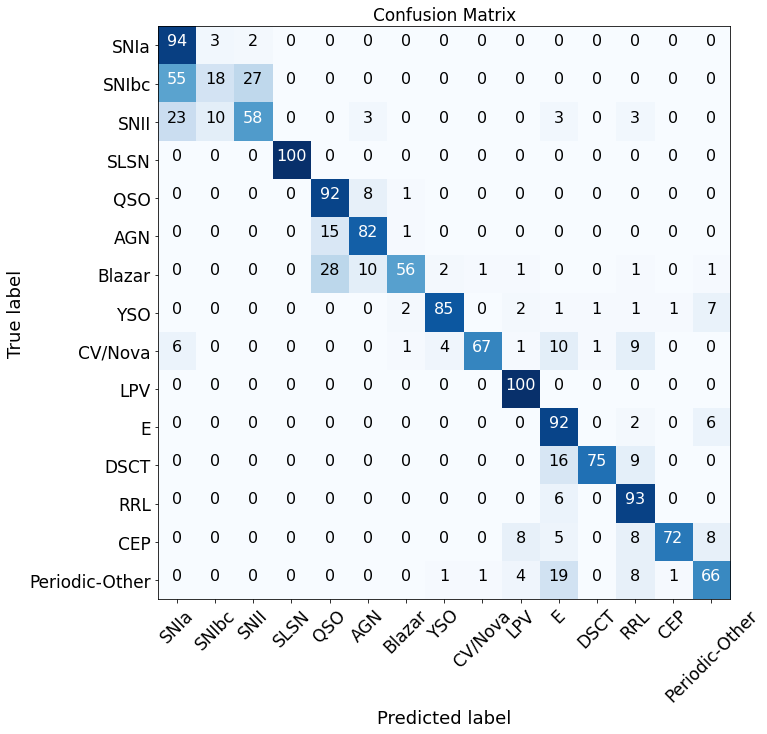

In [ ]:
prediction = student(torch.FloatTensor(hier_val_dataloader.dataset.data).to('cuda'))
one_hot = F.softmax(prediction['logits'],dim=1).to('cpu')
pred_labels = np.array(one_hot.argmax(dim=1))

Precision, Recall, F1score, _ = precision_recall_fscore_support(y_true=hier_val_dataloader.dataset.bottom_labels,
                                                                y_pred=pred_labels,
                                                                pos_label=None, average='macro')
print('Val Metrics:\nPrecision {}\nRecall {}\nF1-Score {}'.format(Precision, Recall,F1score))
cm = confusion_matrix(y_true=hier_val_dataloader.dataset.bottom_labels,
                      y_pred=pred_labels,
                      labels = [13, 14, 12, 11, 9, 6, 7, 10, 8, 3, 2, 1, 5, 0, 4],
                      normalize='true')
plot_confusion_matrix(cm)

Test Metrics:
Precision 0.7606682751905313
Recall 0.734808841697413
F1-Score 0.7351109826292158


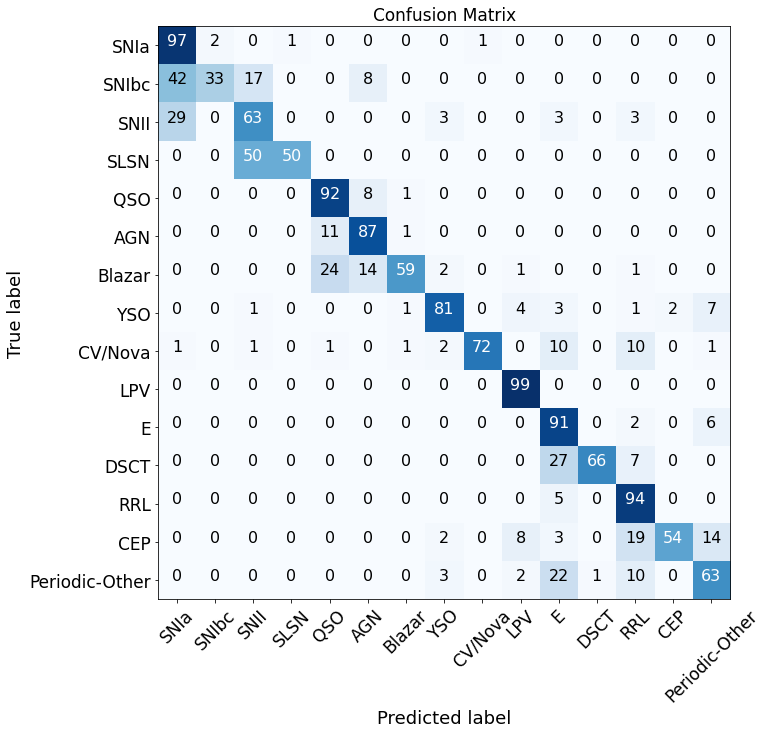

In [ ]:
prediction = student(torch.FloatTensor(hier_test_dataloader.dataset.data).to('cuda'))
one_hot = F.softmax(prediction['logits'],dim=1).to('cpu')
pred_labels = np.array(one_hot.argmax(dim=1))

Precision, Recall, F1score, _ = precision_recall_fscore_support(y_true=hier_test_dataloader.dataset.bottom_labels,
                                                                y_pred=pred_labels,
                                                                pos_label=None, average='macro')
print('Test Metrics:\nPrecision {}\nRecall {}\nF1-Score {}'.format(Precision, Recall,F1score))
cm = confusion_matrix(y_true=hier_test_dataloader.dataset.bottom_labels,
                      y_pred=pred_labels,
                      labels = [13, 14, 12, 11, 9, 6, 7, 10, 8, 3, 2, 1, 5, 0, 4],
                      normalize='true')

plot_confusion_matrix(cm)

Text(0.5, 1.0, 'F1-score')

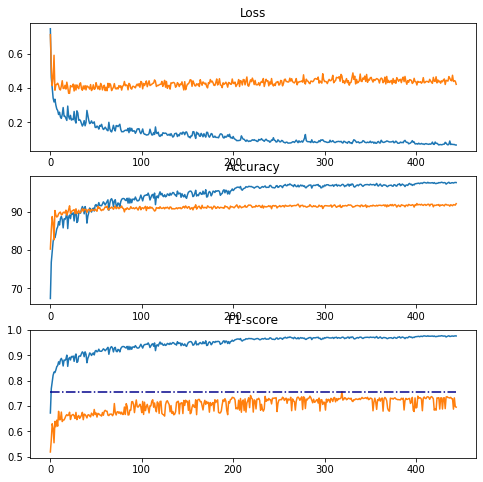

In [ ]:
fig, axs = plt.subplots(3, figsize=(8,8))

axs[0].plot(loss[0])
axs[0].plot(loss[1])
axs[0].set_title('Loss')
axs[1].plot(acc[0])
axs[1].plot(acc[1])
axs[1].set_title('Accuracy')
axs[2].plot(f1[0])
axs[2].plot(f1[1])
axs[2].plot(np.ones(len(f1[0]))*max(f1[1]), '-.', color='darkblue')
axs[2].set_title('F1-score')


Using the Hierarchical model to mix the top-bottom classification

In [ ]:
teacher2 = TopBottomHierarch(top_MLP, student)

Val Metrics:
Precision 0.7648973727940815
Recall 0.764871670018029
F1-Score 0.7550838411039198


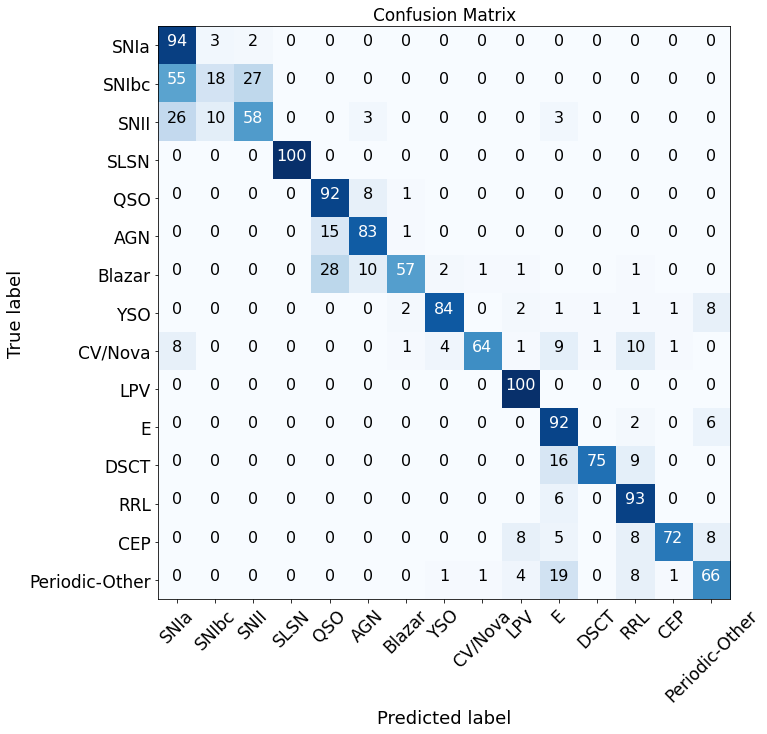

In [ ]:
prediction = teacher2(torch.FloatTensor(hier_val_dataloader.dataset.data).to('cuda'))
one_hot = F.softmax(prediction['logits'],dim=1).to('cpu')
one_hot_t = F.softmax(prediction['top_logits'],dim=1).to('cpu').unsqueeze(dim=1)

one_hot = torch.cat([one_hot_t[:,:,1]*one_hot[:,0:6], 
                     one_hot_t[:,:,2]*one_hot[:,6:11], 
                     one_hot_t[:,:,0]*one_hot[:,11:15]], axis=1)
pred_labels = np.array(one_hot.argmax(dim=1))

Precision, Recall, F1score, _ = precision_recall_fscore_support(y_true=hier_val_dataloader.dataset.bottom_labels,
                                                                y_pred=pred_labels,
                                                                pos_label=None, average='macro')
print('Val Metrics:\nPrecision {}\nRecall {}\nF1-Score {}'.format(Precision, Recall,F1score))
cm = confusion_matrix(y_true=hier_val_dataloader.dataset.bottom_labels,
                      y_pred=pred_labels,
                      labels = [13, 14, 12, 11, 9, 6, 7, 10, 8, 3, 2, 1, 5, 0, 4],
                      normalize='true')
plot_confusion_matrix(cm)

Val Metrics:
Precision 0.7655986970724027
Recall 0.7364247452804379
F1-Score 0.737770049708743


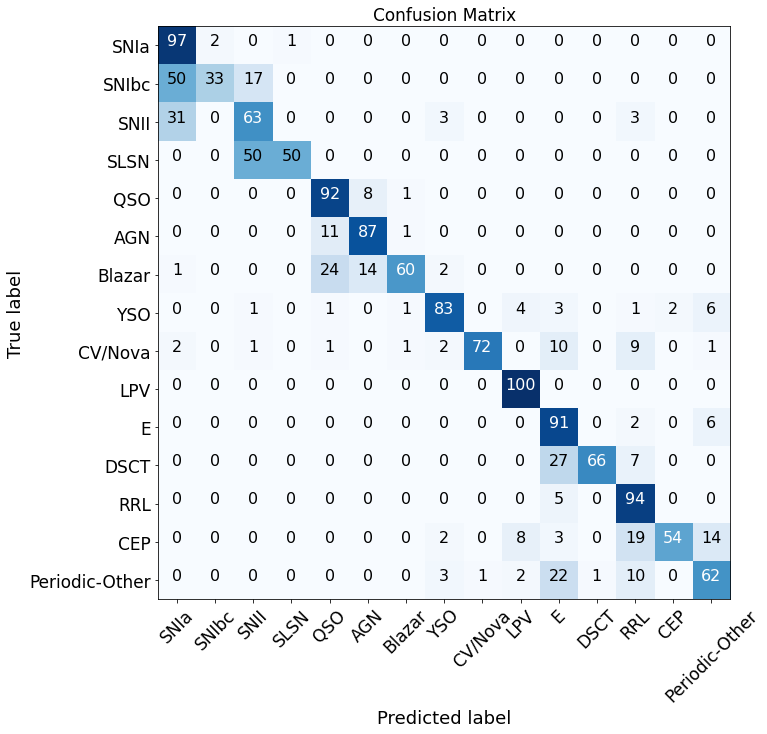

In [ ]:
prediction = teacher2(torch.FloatTensor(hier_test_dataloader.dataset.data).to('cuda'))
one_hot = F.softmax(prediction['logits'],dim=1).to('cpu')
one_hot_t = F.softmax(prediction['top_logits'],dim=1).to('cpu').unsqueeze(dim=1)

one_hot = torch.cat([one_hot_t[:,:,1]*one_hot[:,0:6], 
                     one_hot_t[:,:,2]*one_hot[:,6:11], 
                     one_hot_t[:,:,0]*one_hot[:,11:15]], axis=1)
pred_labels = np.array(one_hot.argmax(dim=1))

Precision, Recall, F1score, _ = precision_recall_fscore_support(y_true=hier_test_dataloader.dataset.bottom_labels,
                                                                y_pred=pred_labels,
                                                                pos_label=None, average='macro')
print('Val Metrics:\nPrecision {}\nRecall {}\nF1-Score {}'.format(Precision, Recall,F1score))
cm = confusion_matrix(y_true=hier_test_dataloader.dataset.bottom_labels,
                      y_pred=pred_labels,
                      labels = [13, 14, 12, 11, 9, 6, 7, 10, 8, 3, 2, 1, 5, 0, 4],
                      normalize='true')
plot_confusion_matrix(cm)

In [ ]:
torch.save(student, 'best_model_kd.pt')

### Second Generation

We use the best model obtained from the first generation of KD between NNs

In [8]:
top_MLP = torch.load('top_model.pt')
bottom_MLP = torch.load('best_model_kd.pt')
teacher = TopBottomHierarch(top_MLP, bottom_MLP)

In [17]:
threshold = 0.75
unlab_list = torch.zeros(0)
soft_list = torch.zeros(0)
for counter in range(int(len(unlab_data)/1024)+1):
  try:
    udata = torch.Tensor(unlab_data[counter*1024:(counter+1)*1024])
    teacher_dict = teacher(torch.FloatTensor(udata).to('cuda'))
    bottom_probs = F.softmax(teacher_dict['logits'],dim=1).to('cpu')
    top_probs = F.softmax(teacher_dict['top_logits'],dim=1).to('cpu').unsqueeze(dim=1)

    probs = torch.cat([top_probs[:,:,1]*bottom_probs[:,0:6], 
                        top_probs[:,:,2]*bottom_probs[:,6:11], 
                        top_probs[:,:,0]*bottom_probs[:,11:15]], axis=1)
    max_probs, _ = torch.max(probs, dim=1)

    valid_idx = torch.where(max_probs > threshold)[0]
    unlab_list = torch.cat([unlab_list, udata[valid_idx]], dim=0)
    soft_list = torch.cat([soft_list, probs[valid_idx]], dim=0)

    del top_probs, bottom_probs, teacher_dict, probs
  except:
    pass
print(len(soft_list))

647012


In [18]:
soft_list = soft_list/soft_list.sum(dim=1).unsqueeze(dim=1)

In [19]:
Hierarch_unlab_dataset = DataSet(unlab_list, soft_list)
unlabeled_dataloader = DataLoader(Hierarch_unlab_dataset,
                                  batch_size=512,
                                  shuffle=True,
                                  num_workers=2)

In [25]:
torch.manual_seed(11)
student = MLP(hidden_dims=[532,282,60]	, function=F.selu, dropout=0.2, out_size=15)

In [26]:
student = student
lr = 5e-3
alpha = 0.5
T = 2
optimizer = optim.Adam(student.parameters(), lr)

loss, acc, f1 = kd_nn2nn_train(student,
                             hier_train_dataloader, hier_val_dataloader, 
                             unlabeled_dataloader, optimizer, 
                             alpha, T, 
                             lr_scheduler=None, epochs=750, 
                             reports_every=1, device='cuda', 
                             patience=125, verbose=True)

Enhanced Validation Metric (inf --> 0.031261).  Saving model ...
Epoch:1(98823/98823), Loss:0.58857, Acc:69.0%
Validation ====> Val Acc:80.58%, F1-score:0.54585, Avg-Time:7.675s.
Enhanced Validation Metric (0.031261 --> 0.545848).  Saving model ...
Epoch:2(98823/98823), Loss:0.37659, Acc:78.7%
Validation ====> Val Acc:86.41%, F1-score:0.56362, Avg-Time:7.332s.
Enhanced Validation Metric (0.545848 --> 0.563621).  Saving model ...
Epoch:3(98823/98823), Loss:0.34180, Acc:80.4%
Validation ====> Val Acc:87.59%, F1-score:0.64675, Avg-Time:7.542s.
Enhanced Validation Metric (0.563621 --> 0.646754).  Saving model ...
Epoch:4(98823/98823), Loss:0.28592, Acc:83.2%
Validation ====> Val Acc:87.65%, F1-score:0.60002, Avg-Time:7.407s.
EarlyStopping counter: 1 out of 125
Epoch:5(98823/98823), Loss:0.27746, Acc:83.9%
Validation ====> Val Acc:86.53%, F1-score:0.59042, Avg-Time:7.480s.
EarlyStopping counter: 2 out of 125
Epoch:6(98823/98823), Loss:0.28594, Acc:83.4%
Validation ====> Val Acc:86.72%, F1-s

Val Metrics:
Precision 0.7758782209130692
Recall 0.7336522390195184
F1-Score 0.7402183420910066


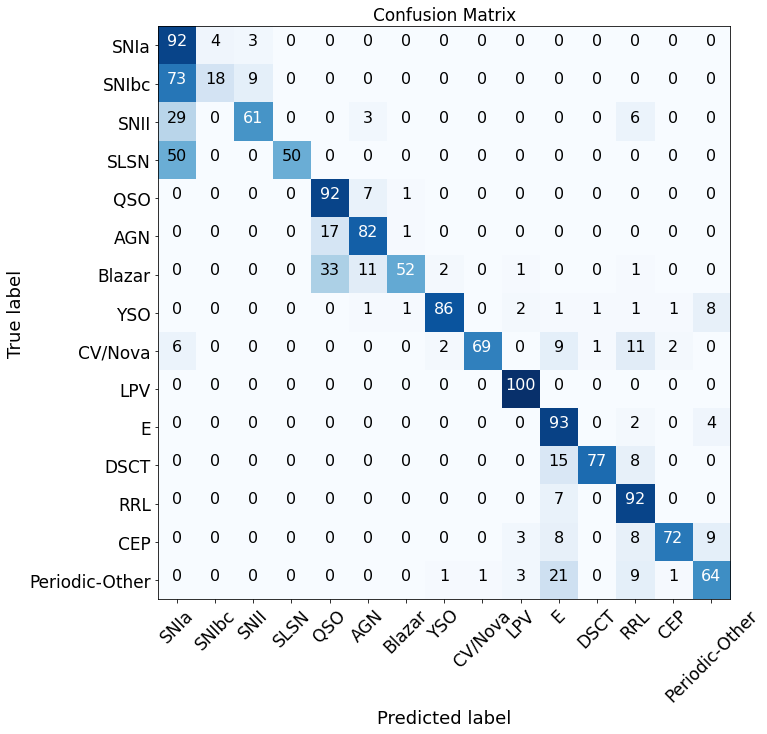

In [27]:
prediction = student(torch.FloatTensor(hier_val_dataloader.dataset.data).to('cuda'))
one_hot = F.softmax(prediction['logits'],dim=1).to('cpu')
pred_labels = np.array(one_hot.argmax(dim=1))

Precision, Recall, F1score, _ = precision_recall_fscore_support(y_true=hier_val_dataloader.dataset.bottom_labels,
                                                                y_pred=pred_labels,
                                                                pos_label=None, average='macro')
print('Val Metrics:\nPrecision {}\nRecall {}\nF1-Score {}'.format(Precision, Recall,F1score))
cm = confusion_matrix(y_true=hier_val_dataloader.dataset.bottom_labels,
                      y_pred=pred_labels,
                      labels = [13, 14, 12, 11, 9, 6, 7, 10, 8, 3, 2, 1, 5, 0, 4],
                      normalize='true')
plot_confusion_matrix(cm)

Test Metrics:
Precision 0.7442185694403991
Recall 0.7056020022558166
F1-Score 0.7111436331753995


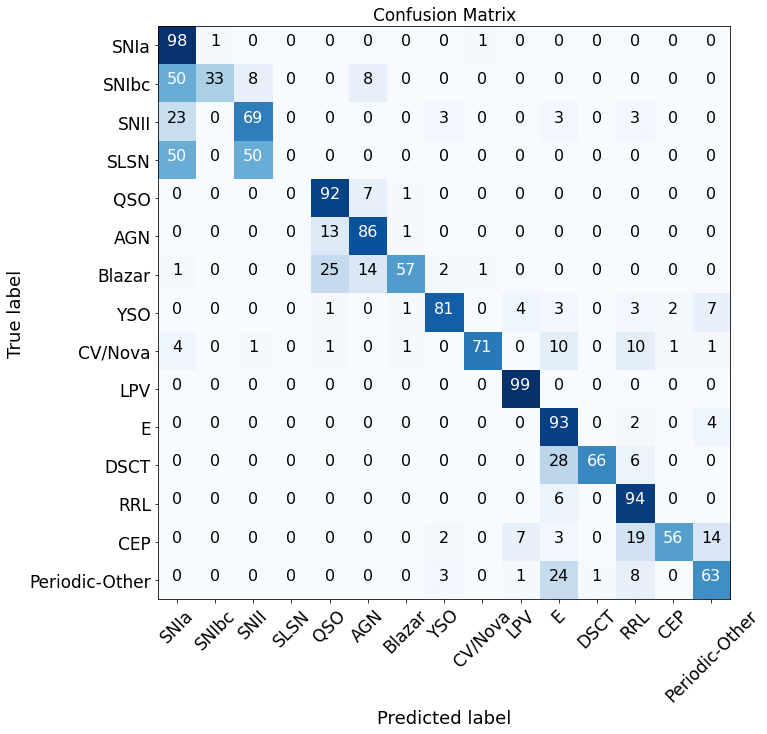

In [28]:
prediction = student(torch.FloatTensor(hier_test_dataloader.dataset.data).to('cuda'))
one_hot = F.softmax(prediction['logits'],dim=1).to('cpu')
pred_labels = np.array(one_hot.argmax(dim=1))

Precision, Recall, F1score, _ = precision_recall_fscore_support(y_true=hier_test_dataloader.dataset.bottom_labels,
                                                                y_pred=pred_labels,
                                                                pos_label=None, average='macro')
print('Test Metrics:\nPrecision {}\nRecall {}\nF1-Score {}'.format(Precision, Recall,F1score))
cm = confusion_matrix(y_true=hier_test_dataloader.dataset.bottom_labels,
                      y_pred=pred_labels,
                      labels = [13, 14, 12, 11, 9, 6, 7, 10, 8, 3, 2, 1, 5, 0, 4],
                      normalize='true')

plot_confusion_matrix(cm)

Text(0.5, 1.0, 'F1-score')

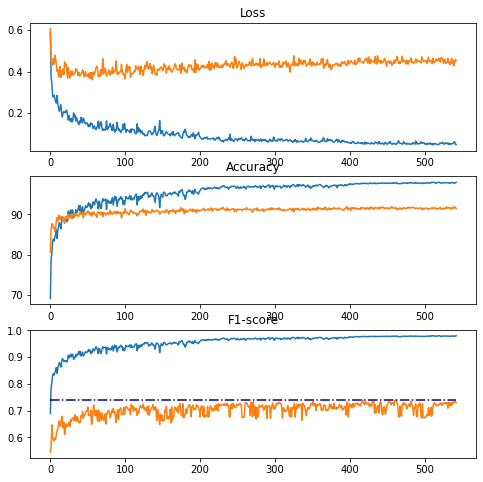

In [29]:
fig, axs = plt.subplots(3, figsize=(8,8))

axs[0].plot(loss[0])
axs[0].plot(loss[1])
axs[0].set_title('Loss')
axs[1].plot(acc[0])
axs[1].plot(acc[1])
axs[1].set_title('Accuracy')
axs[2].plot(f1[0])
axs[2].plot(f1[1])
axs[2].plot(np.ones(len(f1[0]))*max(f1[1]), '-.', color='darkblue')
axs[2].set_title('F1-score')
